In [2]:
import folium
import pandas as pd
import branca
import requests
import json
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress

%matplotlib inline


In [6]:
# all_county_pop_df = pd.read_csv("../../data/Demographics/all_county_pop.csv",encoding='latin-1')
# all_county_pop_df = all_county_pop_df[["STNAME","POPESTIMATE2019"]]

In [11]:
# all_county_pop_df.head()

,STNAME,POPESTIMATE2019
0,Alabama,4903185
1,Alabama,55869
2,Alabama,223234
3,Alabama,24686
4,Alabama,22394


In [12]:
#nyt_df = pd.read_csv("../../data/nyt/covid-19-data-master/us-counties.csv",na_values=[' '])
nyt_df = pd.read_csv("../../data/nyt/covid-19-data-master/us-states.csv", na_values=[' '])

abrvs = pd.read_table("../../../COVID datascience/State Abbreviations Code Table.tsv")
nyt_df = nyt_df.set_index('state').join(abrvs.set_index('Description'))
#nyt_df=nyt_df.join(all_county_pop_df.set_index("STNAME"))

#case_series = nyt_df.set_index("Code")["cases"]
colorscale_3 = branca.colormap.linear.YlOrRd_09.scale(0, max(nyt_df["cases"]+10))

In [107]:
# Testing data
test_df = pd.read_csv("../../data/Health Policy/State COVID-19 Testing.csv", skiprows=2)
test_df = test_df.set_index("Location").join(abrvs.set_index('Description'))

In [113]:
# Medicaid
insurance_df = pd.read_csv("../../data/Health Policy/Medicaid Expansion Status and Health Insurance Coverage.csv",skiprows=2)
insurance_df = insurance_df.set_index("Location").join(abrvs.set_index('Description'))

In [127]:
# Insurance deductibles
insurance_deduct_df = pd.read_csv("../../data/Health Policy/Private Insurance Deductibles and Self-Insured Plans.csv",skiprows=2)
insurance_deduct_df = insurance_deduct_df.set_index("Location").join(abrvs.set_index('Description'))
c = "Average Family Deductible for Employer-Sponsored Insurance"
insurance_deduct_df[c] = [float(str(x)[1:]) if str(x) != "nan" else float("nan") for x in list(insurance_deduct_df[c])  ]

In [128]:
visualize(insurance_deduct_df, c)

In [114]:
visualize(insurance_df,"Uninsured")

In [109]:
visualize(test_df,"Share of Tests with Positive COVID-19 Results")

In [26]:
# Feature engineering
nyt_df["log cases"]  = np.log(np.array(nyt_df["cases"]))
nyt_df["log deaths"] = np.log(np.array(nyt_df["deaths"]))


#nyt_df["cases per cap"] = nyt_df["cases"]/nyt_df["POPESTIMATE2019"]
#nyt_df["log cases per cap"] = np.log(nyt_df["cases"]/nyt_df["POPESTIMATE2019"])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Get most recent day
date = "2020-04-03"
nyt_df_recent = nyt_df[nyt_df["date"] == date]


In [ ]:
plt.hist(nyt_df_recent["log cases per cap"])

In [95]:
def visualize(df, column, html_save=None):
    url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
    state_geo = f'{url}/us-states.json'
    #state_unemployment = f'{url}/US_Unemployment_Oct2012.csv'
    #state_data = pd.read_csv(state_unemployment)

    m = folium.Map(location=[48, -102], zoom_start=3)

    folium.Choropleth(
        geo_data=state_geo,
        name='choropleth',
    #    data=nyt_df_recent,
            data=df,
        columns=['Code', column],
        key_on='feature.id',
        fill_color='YlOrRd',
        fill_opacity=0.7,
        line_opacity=0.2,
        legend_name=column
    ).add_to(m)

    folium.LayerControl().add_to(m)
    
    return m
    
#     if html_save:
#         m.save("infection.html")

In [24]:
m = visualize(nyt_df,"cases")


In [47]:
# Model the growth rate

def fit_linear_models_all_states(df, column):

    model_data = {}
    
    for state in set(df.index):
        #print(state)
        data = np.array((df.loc[state][column]))
        data = [x for x in data if x > 1]
        if len(data) > 0:
            
            lr = linregress(range(len(data)), data)

            model_data[state] = (lr, data)
      
    return model_data

In [53]:
case_model_data = fit_linear_models_all_states(nyt_df, "log cases")
death_model_data = fit_linear_models_all_states(nyt_df, "log deaths")


NameError: name 'state' is not defined

In [59]:
nyt_df["Infection Rates"] = [case_model_data[state][0].slope for state in nyt_df.index]
nyt_df["Death Rates"] = [ death_model_data[state][0].slope if state in death_model_data else 0 for state in nyt_df.index]

In [60]:
visualize(nyt_df, "Infection Rates")

In [61]:
visualize(nyt_df, "Death Rates")

# Plot difference between infection rate and death rate

In [65]:
col = "Case-Death Rate Differential"
nyt_df[col] = nyt_df["Infection Rates"] - nyt_df["Death Rates"]
visualize(nyt_df, col)

In [97]:
col = "Death-Case Rate Differential"
nyt_df[col] =  nyt_df["Death Rates"] - nyt_df["Infection Rates"]
visualize(nyt_df, col)

# Regression Scores

In [96]:
nyt_df["Model Fit R"] = [case_model_data[state][0].rvalue for state in nyt_df.index]
nyt_df["Model Fit R2"] = nyt_df["Model Fit R"]*nyt_df["Model Fit R"]
visualize(nyt_df, "Model Fit R2")

In [80]:
def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--', label="model")

In [88]:
model.rvalue

0.9622756032298534

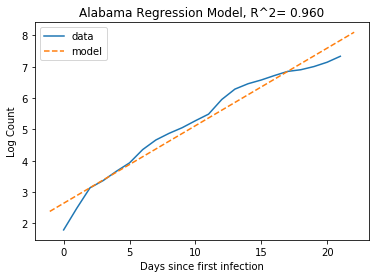

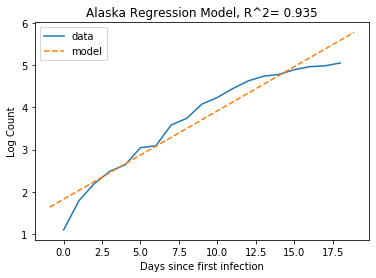

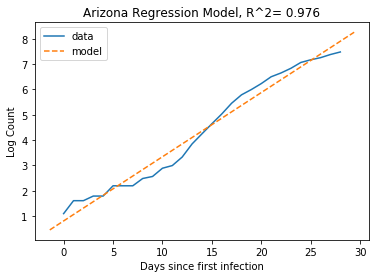

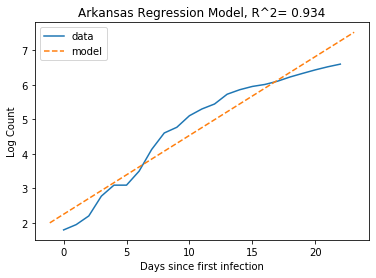

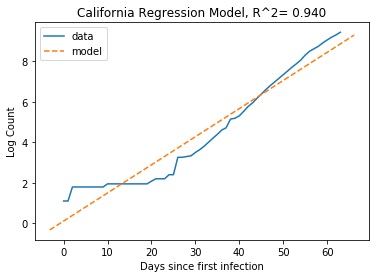

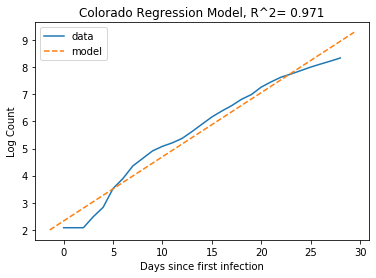

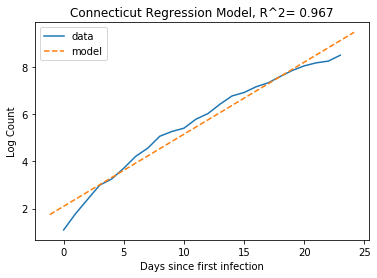

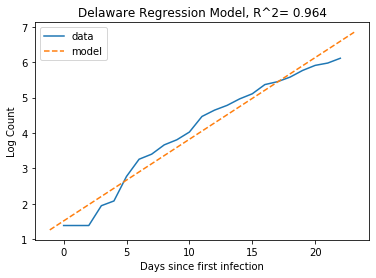

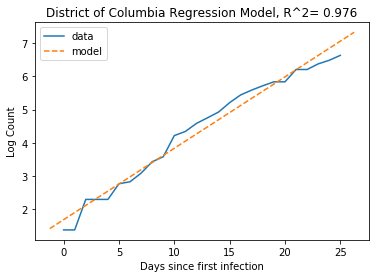

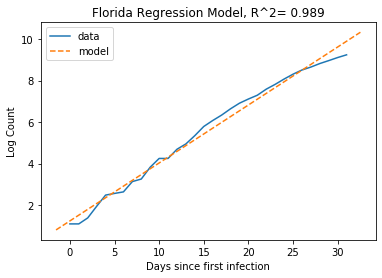

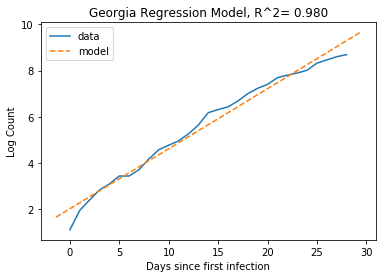

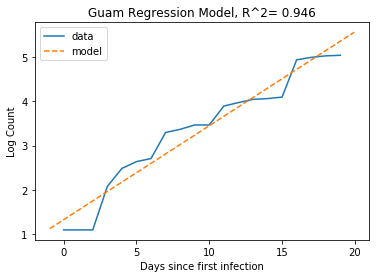

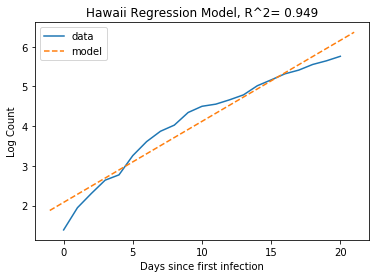

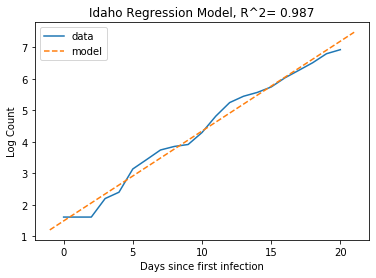

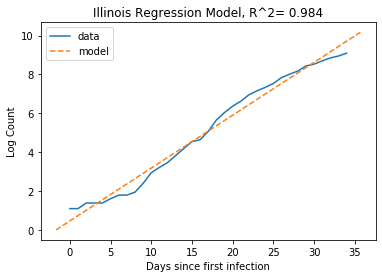

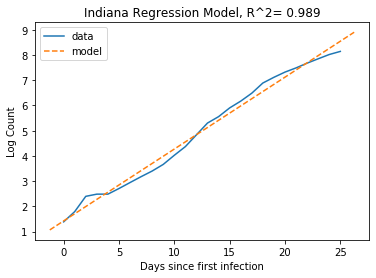

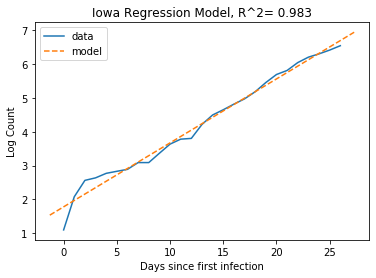

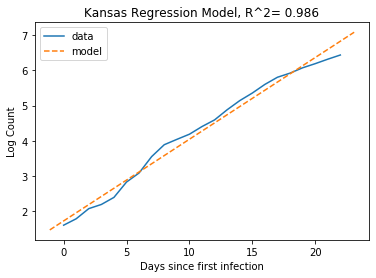

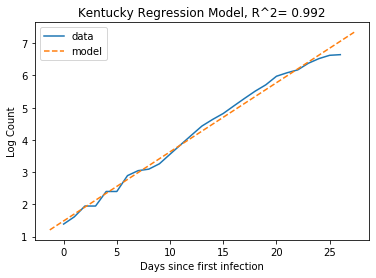

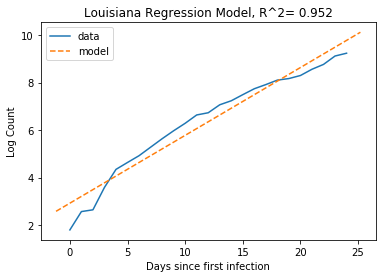

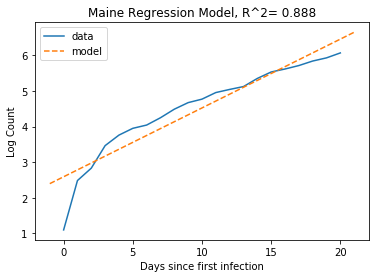

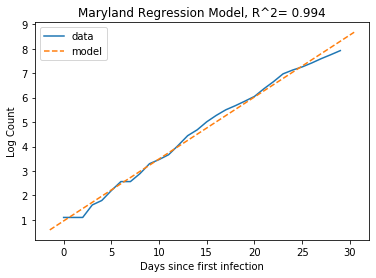

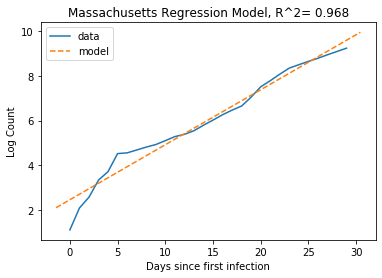

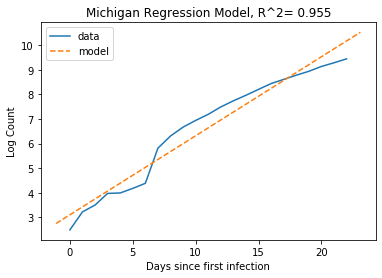

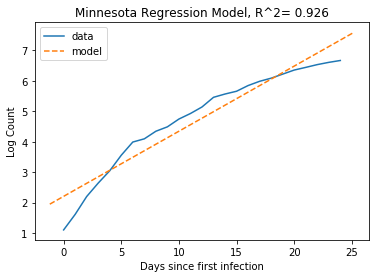

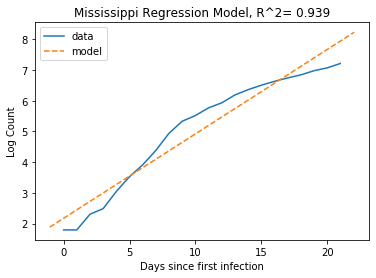

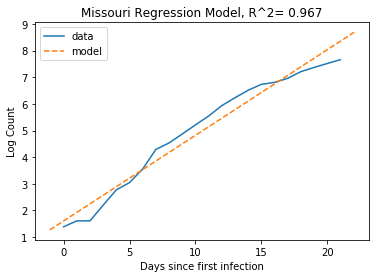

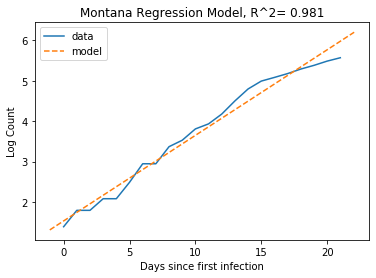

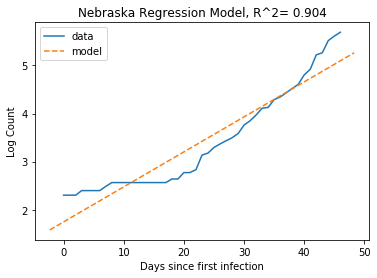

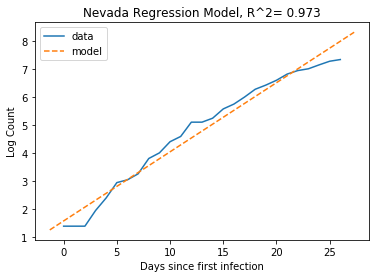

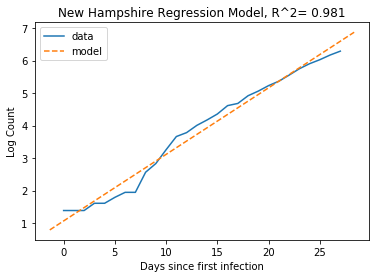

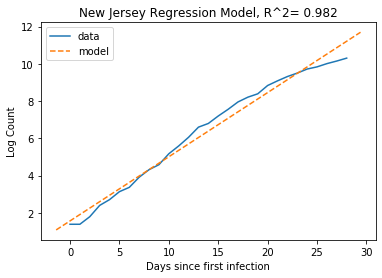

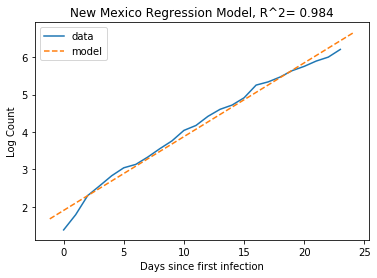

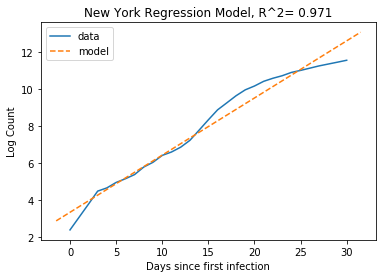

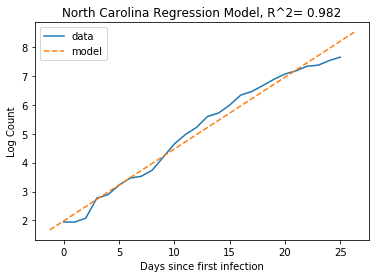

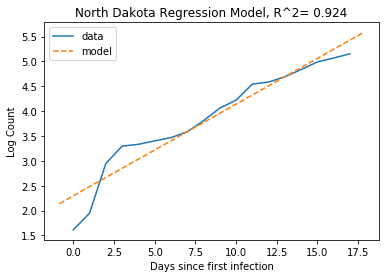

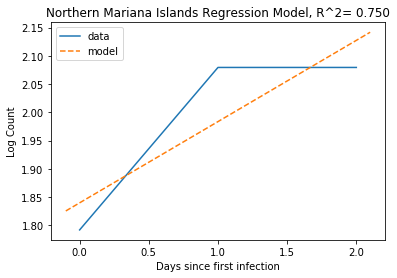

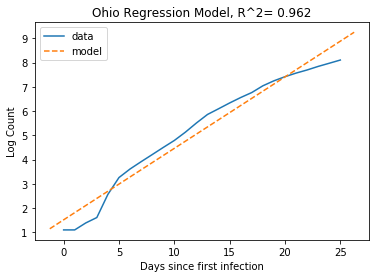

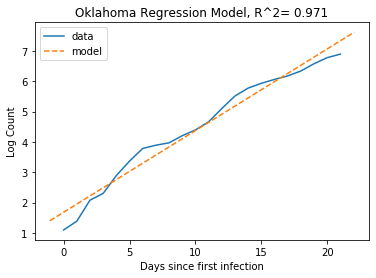

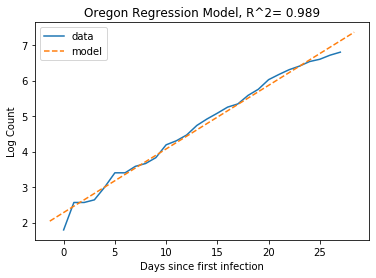

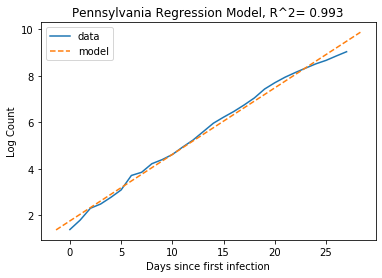

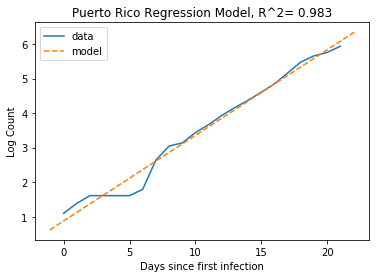

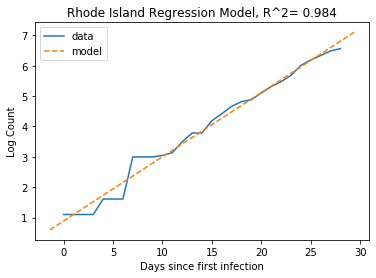

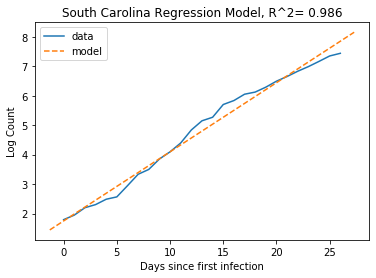

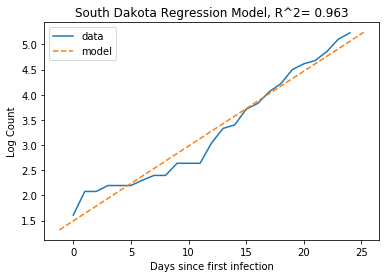

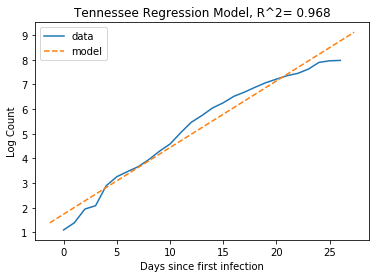

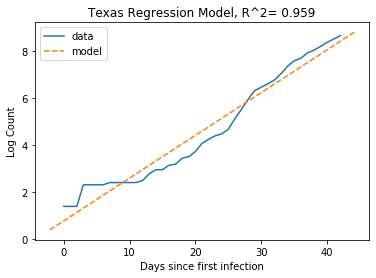

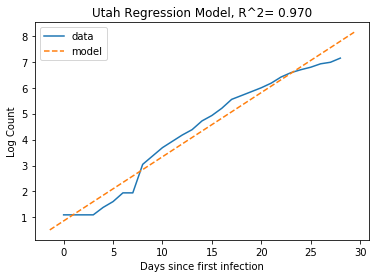

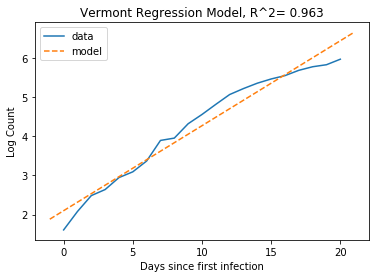

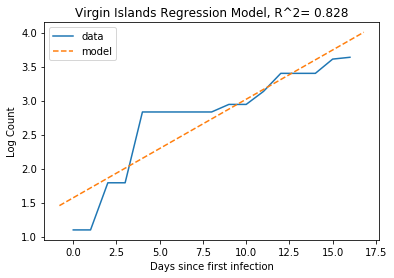

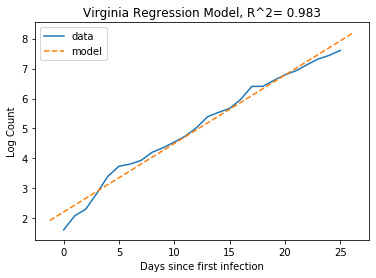

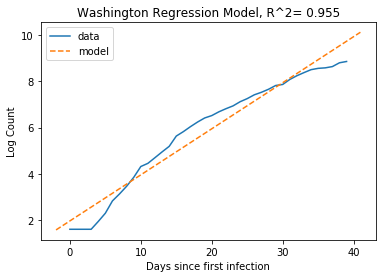

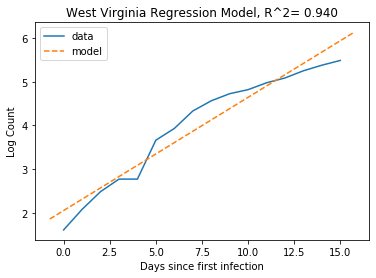

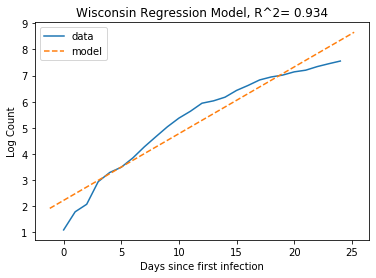

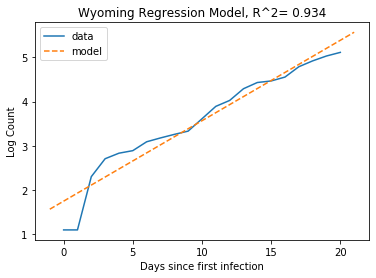

In [94]:
# Save regression plots
states = list(set(nyt_df.index))
states.sort()
for state in states:
    #print(state)
    #print(case_model_data[state][0].rvalue )
    #print(case_model_data[state][1])
    
    data = case_model_data[state][1]
    model = case_model_data[state][0]
    plt.xlabel("Days since first infection")
    plt.ylabel("Log Count")
    
    plt.plot(data,label="data")
    
    plt.title(state + " Regression Model, R^2= {}".format("%.3f" % (model.rvalue*model.rvalue)))
    
    
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = model.intercept + model.slope * x_vals
    plt.plot(x_vals, y_vals, '--', label="model")
    
    plt.legend()
    
    plt.show()

In [ ]:

url = 'https://raw.githubusercontent.com/python-visualization/folium/master/examples/data'
county_data = f'{url}/us_county_data.csv'
county_geo = f'{url}/us_counties_20m_topo.json'
state_geo = f'{url}/us-states.json'


df = pd.read_csv(county_data, na_values=[' '])

colorscale = branca.colormap.linear.YlOrRd_09.scale(0, 50e3)
employed_series = df.set_index('FIPS_Code')['Employed_2011']


In [ ]:
county_data

In [ ]:
len(set(nyt_df["fips"]))

In [ ]:
fip_death_rates = pd.read_csv("fip_death_rates.csv")
fip_death_rates = fip_death_rates.sort_values(by="fip")
fip_death_rates_good_fit = fip_death_rates[fip_death_rates["rvals"]>0.8]

In [ ]:
colorscale_3

In [ ]:
death_rate_series = fip_death_rates_good_fit.set_index('fip')['slope']


In [ ]:
colorscale_2 = branca.colormap.linear.YlOrRd_09.scale(0, 1)

In [ ]:
type(employed_series)

In [ ]:
type(case_series)

In [ ]:


def style_function(feature):
#    print("feature:", feature)
    fip = int(feature['id'][-5:])
    
    try:
        data = list(case_series.get(fip, None))
        data.sort()
        data = data[-1]
       # print(fip, data)
    except:
        data = None
        
    return {
        'fillOpacity': 0.5,
        'weight': 0,
        'fillColor': '#white' if data is None else colorscale_3(data)
    }


m = folium.Map(
    location=[48, -102],
    tiles='cartodbpositron',
    zoom_start=3
)

folium.TopoJson(
    json.loads(requests.get(state_geo).text),
    'objects.us-states',
    style_function=style_function
).add_to(m)


# folium.TopoJson(
#     json.loads(requests.get(county_geo).text),
#     'objects.us_counties_20m',
#     style_function=style_function
# ).add_to(m)

# def style_function(feature):
#     employed = employed_series.get(int(feature['id'][-5:]), None)
#     return {
#         'fillOpacity': 0.5,
#         'weight': 0,
#         'fillColor': '#black' if employed is None else colorscale(employed)
#     }


# m = folium.Map(
#     location=[48, -102],
#     tiles='cartodbpositron',
#     zoom_start=3
# )

# folium.TopoJson(
#     json.loads(requests.get(county_geo).text),
#     'objects.us_counties_20m',
#     style_function=style_function
# ).add_to(m)

In [ ]:
m